# Import the required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
import pandas as pd
from osgeo import gdal

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Creation of model object and application of MODFLOW NWT

In [3]:
modelname = 'model'
work_ws = 'Model'
mf = flopy.modflow.Modflow(modelname, exe_name="/home/bojichen/.local/share/flopy/bin/mfnwt", version='mfnwt', model_ws=work_ws)

#Defininition of MODFLOW NWT Solver
nwt = flopy.modflow.ModflowNwt(mf, maxiterout=200, linmeth=2, headtol=0.01)

In [4]:
demPath = "./GIS/dem3m_bound.tif"
crPath = "./GIS/mask_final.tif"

In [5]:
demDs =gdal.Open(demPath)  # type: gdal.Dataset
crDs = gdal.Open(crPath)
geot = crDs.GetGeoTransform() #Xmin, deltax, ?, ymax, ?, delta y

In [6]:
demData = demDs.GetRasterBand(1).ReadAsArray()
crData = crDs.GetRasterBand(1).ReadAsArray()

In [7]:
demData = demData[:1270,:1030]
demData[demData<0] = 0

In [8]:
Layer1 = demData - 1
Layer2 = demData - 4
Layer3 = (Layer2 + 10) * 0.8 - 10
Layer4 = (Layer2 + 10) * 0.5 - 10
Layer5 = -10

In [9]:
#Boundaries for Dis = Create discretization object, spatial/temporal discretization
ztop = demData
zbot = [Layer1, Layer2, Layer3, Layer4, Layer5]
nlay = 5
nrow = demData.shape[0]
ncol = demData.shape[1]
delr = geot[1]
delc = abs(geot[5])

In [10]:
dis = flopy.modflow.ModflowDis(mf, nlay,nrow,ncol,delr=delr,delc=delc,top=ztop,botm=zbot,itmuni=1)

In [11]:
iboundData = np.zeros(demData.shape, dtype=np.int32)
iboundData[crData != 0 ] = 1

In [12]:
bas = flopy.modflow.ModflowBas(mf,ibound=iboundData,strt=0, hnoflo=-2.0E+020)

In [13]:
#hk = [1E-4, 2E-5, 2E-5, 5E-6,5E-7]
hk = [1.5E-5, 1.5E-5, 1.5E-5, 5E-6, 5E-7]

In [14]:
upw = flopy.modflow.ModflowUpw(mf, laytyp = [1,1,1,1,0], hk = hk)

In [15]:
evtr = np.ones((nrow, ncol), dtype=np.float32) * 1/365/86400
evtr_data = {0: evtr}
evt = flopy.modflow.ModflowEvt(mf,nevtop=1,surf=ztop,evtr=evtr_data, exdp=1)

In [16]:
rch = np.ones((nrow, ncol), dtype=np.float32) * 1.1/365/86400
rch_data = {0: rch}
rch = flopy.modflow.ModflowRch(mf, nrchop=3, rech =rch_data)

In [17]:
riv = np.zeros((nrow, ncol), dtype=np.float32)
riv[(crData ==333)] = 1
list = []
for i in range(nrow):
    for j in range(ncol):
        if riv[i,j] == 1:
            list.append([0,i,j,ztop[i,j],0.01, ztop[i,j]-1])  # [layer, row, column, stage, cond, rbot]
riv_spd = {0: list}
riv = flopy.modflow.ModflowRiv(mf, ipakcb=53, stress_period_data=riv_spd)

In [18]:
chd = np.zeros(demData.shape, dtype=np.int32)
chd[(crData == 222)] = 1
list = []
for k in range(nlay):
    for i in range(chd.shape[0]):
        for q in range(chd.shape[1]):
            if chd[i,q] == 1:
                list.append([k, i, q, ztop[i,q], ztop[i,q]]) #layer,row,column,elevation(float),conductanceee
chd_spd = {0:list}
chd = flopy.modflow.ModflowChd(mf, stress_period_data=chd_spd)

In [19]:
from pysheds.grid import Grid

grid = Grid.from_raster(r'./GIS/dem3m_bound.tif')
dem = grid.read_raster(r'./GIS/dem3m_bound.tif')

# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

acc = grid.accumulation(fdir, dirmap=dirmap)

In [20]:
# create a drain package
drn = np.zeros(demData.shape, dtype=np.int32)
lst = []
for i in range(drn.shape[0]):
    for q in range(drn.shape[1]):
        if ((ztop[i,q] < 40 or acc[i,q] > 1000) and crData[i,q] != 222 and crData[i,q] != 333 and iboundData[i,q] == 1):
        # if crData[i,q] == 111 or (slopeData[i,q] > 30 and iboundData[i,q] == 1 and crData[i,q] != 222 and crData[i,q] != 333):
            drn[i,q] == 1
            elevation = ztop[i,q]
            lst.append([0,i,q,elevation, hk[0]*10]) #layer,row,column, starting head, ending head
drn_spd = {0:lst}
drn = flopy.modflow.ModflowDrn(mf, stress_period_data=drn_spd)

In [21]:
# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf) #ihedfm= 1, iddnfm=1

# Write files of the MODFLOW model and run simulation

In [22]:
mf.write_input()

In [23]:
mf.run_model()

FloPy is using the following executable to run the model: ../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/13 14:19:20

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/10/13 15:18:48
 Elapsed run time: 59 Minutes, 28.278 Seconds

  Normal termination of simulation


(True, [])

In [24]:
ml = flopy.modflow.Modflow.load('./Model/model.nam')

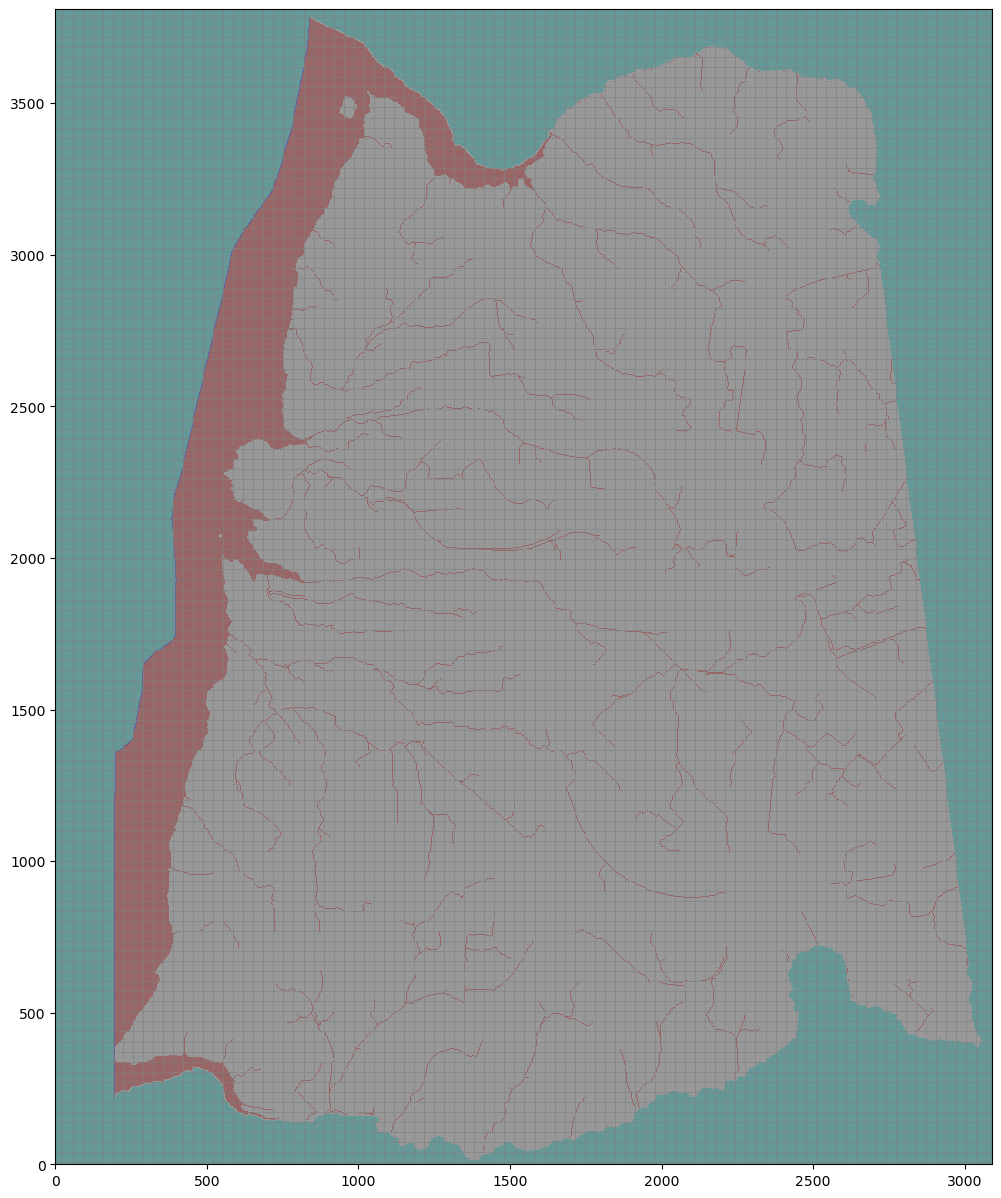

In [25]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=ml)
modelmap.plot_bc('DRN', color='red')
modelmap.plot_bc('CHD', color='blue')

# modelmap.plot_bc('RCH', color='green')
quadmesh = modelmap.plot_ibound(color_noflow='cyan')
linecollection = modelmap.plot_grid(linewidth=0.4)

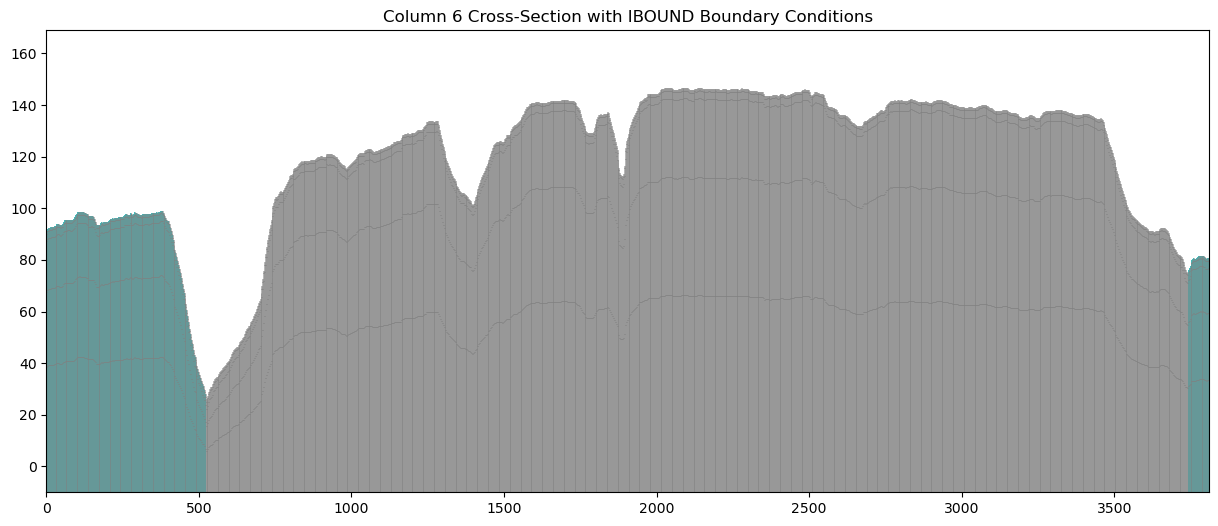

In [26]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=ml, line={'Column': 500})
patches = modelxsect.plot_ibound(color_noflow='cyan')
linecollection = modelxsect.plot_grid(linewidth=0.4)
t = ax.set_title('Column 6 Cross-Section with IBOUND Boundary Conditions')

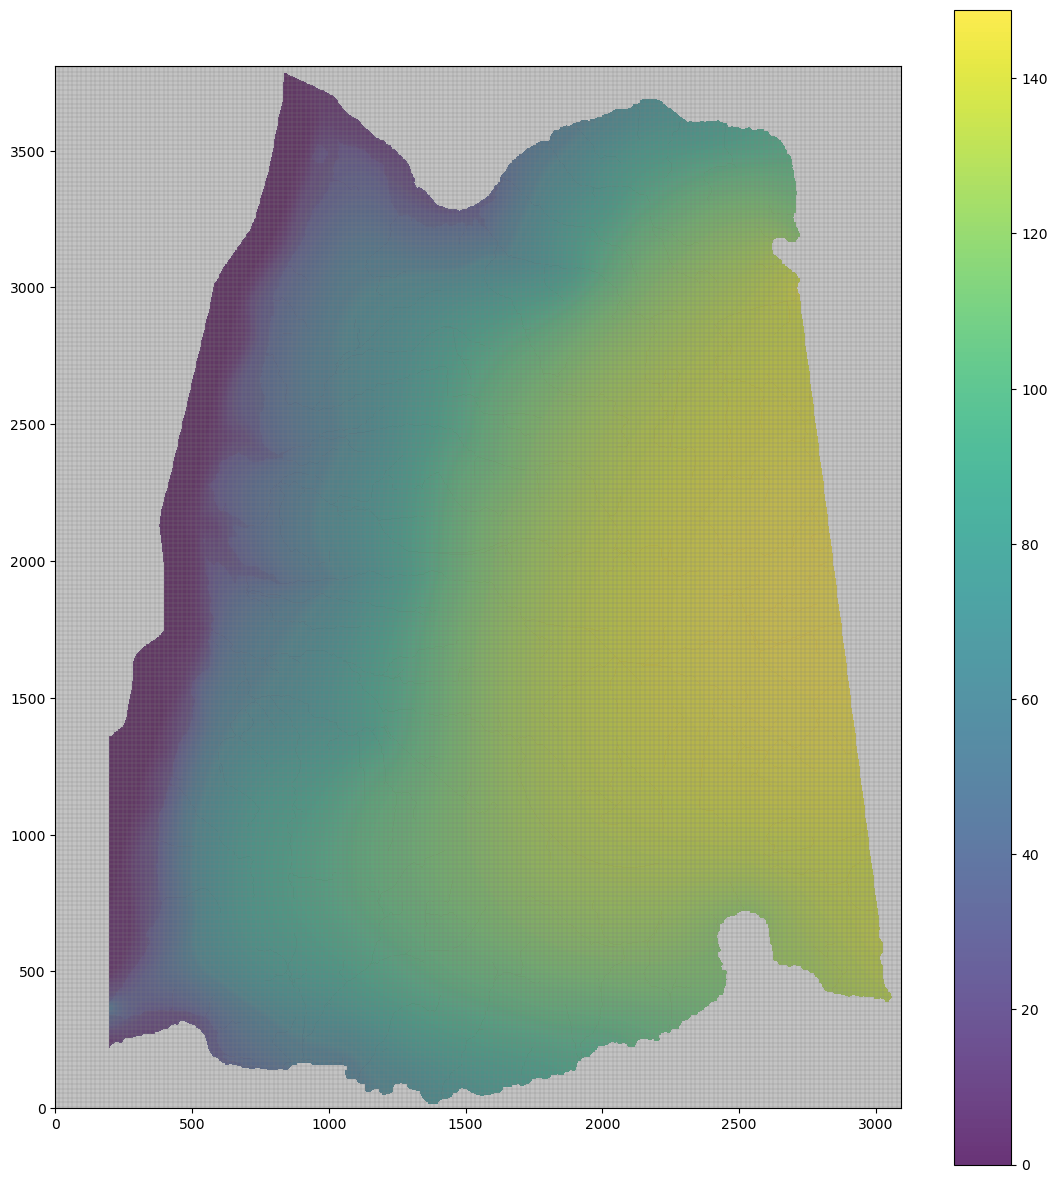

In [27]:
hdobj = flopy.utils.HeadFile('./Model/model.hds')
head = hdobj.get_data()

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=ml)
modelmap.plot_bc('DRN', color='red')
#quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, alpha=0.8)
linecollection = modelmap.plot_grid(linewidth=0.2)
plt.colorbar(quadmesh, ax=ax, shrink=0.5)
plt.show()

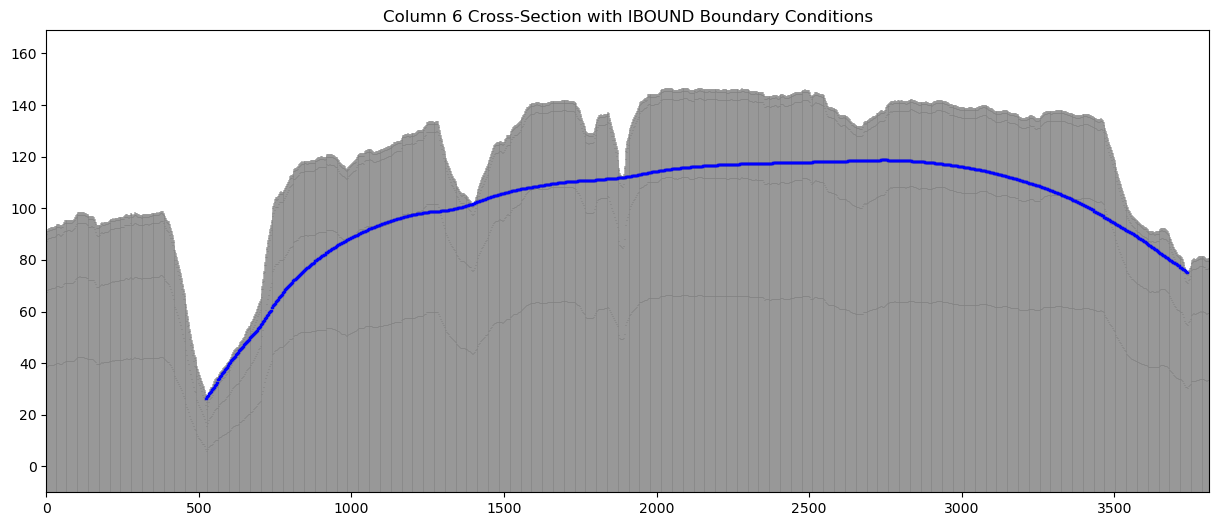

In [28]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=ml, line={'Column': 500})
linecollection = modelxsect.plot_grid(linewidth=0.4)
linecollection = modelxsect.plot_surface(head,ax=ax)
t = ax.set_title('Column 6 Cross-Section with IBOUND Boundary Conditions')

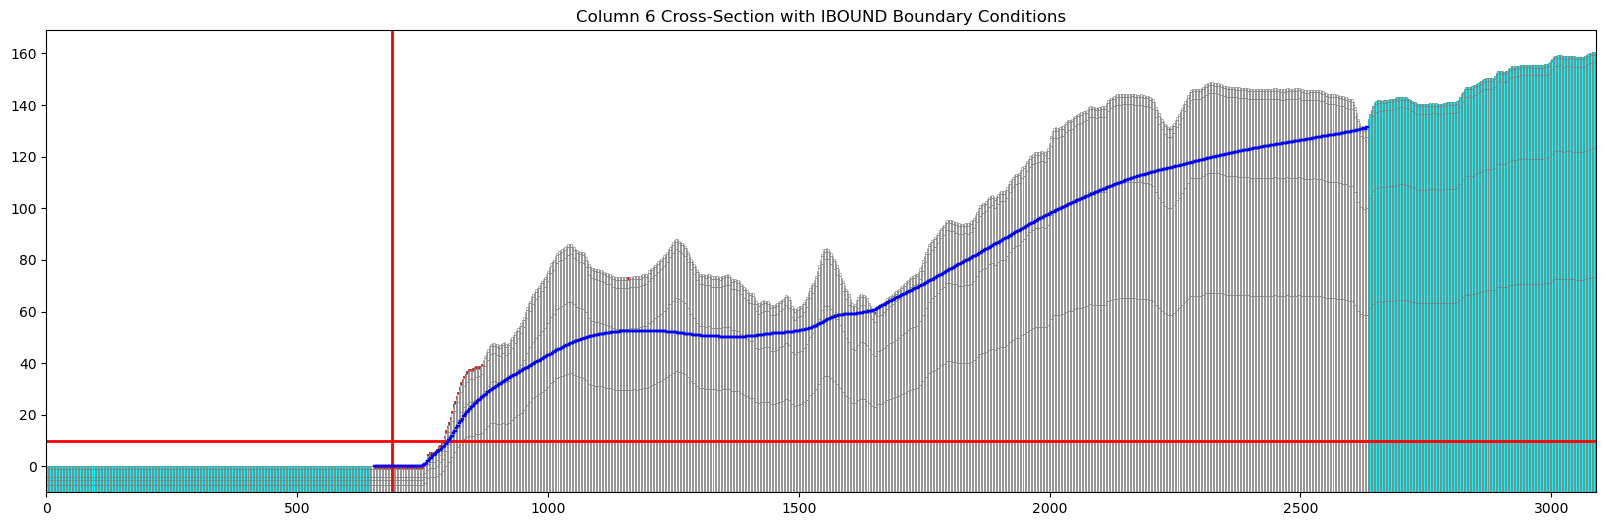

In [29]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=ml, line={'Row': 230})
modelxsect.plot_ibound(color_noflow='cyan')
# plot the vertical lines
plt.axvline(x= 230 * 3, color='red', lw=2)
# patches = modelxsect.plot_bc('CHD', color='red')
modelxsect.plot_bc('DRN', color='red')
# plot the horizontal lines
plt.axhline(y = 10, color='red', lw=2)
linecollection = modelxsect.plot_grid(linewidth=0.4)
linecollection = modelxsect.plot_surface(head,ax=ax)
t = ax.set_title('Column 6 Cross-Section with IBOUND Boundary Conditions')

In [30]:
# read the headfile and extract heads for [547, 241]
headobj = flopy.utils.HeadFile('./Model/model.hds')
head = headobj.get_data()
head[0, 560, 230]

33.641647

In [31]:
ztop[560, 230]

36.48485

In [32]:
33.64-36.48

-2.8399999999999963

In [33]:
0.01 * 60 * 60 * 24

864.0